# random forest prediction + clustering -ET_project(original 




In [1]:
pip install basemap basemap-data-hires


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [5]:
df= pd.read_csv('/home/antqua/code/AntQua/ET_Predictor/Notebooks/preprocessfinalproprosal.csv')

In [6]:
df.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)      float64
duration (hours/min)     object
comments                 object
date posted              object
latitude                float64
longitude               float64
dtype: object

In [7]:
# Convert 'datetime' to datetime object, coerce errors
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Extract year, month, day, hour, and minute from datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

In [8]:
df.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
year                             int32
month                            int32
day                              int32
hour                             int32
minute                           int32
dtype: object

#### Defining X and y

In [9]:
# Drop rows where datetime could not be converted
df.dropna(subset=['datetime'], inplace=True)

# Define features and target variable
X = df.drop(columns=['latitude', 'longitude'])
y = df[['latitude', 'longitude']]


In [10]:
# Define features and target variables
features = ['duration (seconds)', 'year', 'month', 'day', 'hour', 'minute']
X = df[features]
y_lat = df['latitude']
y_long = df['longitude']

# Split the data into training and test sets
X_train, X_test, y_lat_train, y_lat_test, y_long_train, y_long_test = train_test_split(X, y_lat, y_long, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor models
rf_reg_lat = RandomForestRegressor(random_state=42)
rf_reg_lat.fit(X_train_scaled, y_lat_train)

rf_reg_long = RandomForestRegressor(random_state=42)
rf_reg_long.fit(X_train_scaled, y_long_train)

RandomForestRegressor(random_state=42)

In [11]:
# Predict and evaluate the models
y_lat_pred_rf = rf_reg_lat.predict(X_test_scaled)
y_long_pred_rf = rf_reg_long.predict(X_test_scaled)

mae_lat_rf = median_absolute_error(y_lat_test, y_lat_pred_rf)
mae_long_rf = median_absolute_error(y_long_test, y_long_pred_rf)

mae_results = {
    'Random Forest Latitude MAE': mae_lat_rf,
    'Random Forest Longitude MAE': mae_long_rf,
}

mae_results

{'Random Forest Latitude MAE': 3.577620432000021,
 'Random Forest Longitude MAE': 14.520434782500026}

In [12]:
# Example prediction for a future chosen date
future_date = pd.to_datetime('2024-10-04 00:00:00')
future_duration = 120  # example duration in seconds

future_features = pd.DataFrame({
    'duration (seconds)': [future_duration],
    'year': [future_date.year],
    'month': [future_date.month],
    'day': [future_date.day],
    'hour': [future_date.hour],
    'minute': [future_date.minute]
})

future_features_scaled = scaler.transform(future_features)

# Predict latitude and longitude using both models
predicted_lat_rf = rf_reg_lat.predict(future_features_scaled)
predicted_long_rf = rf_reg_long.predict(future_features_scaled)

predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

print(f"Predicted location (Random Forest): {predicted_location_rf}")

Predicted location (Random Forest): (37.969950591999975, -90.78647178599998)


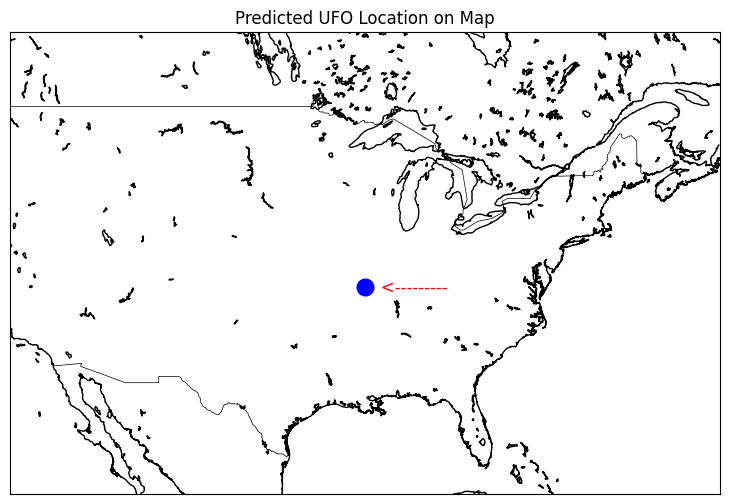

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

predicted_location_rf = (predicted_lat_rf, predicted_long_rf)

# Create a figure
plt.figure(figsize=(15, 6))

# Create a Basemap instance with a larger scale
m = Basemap(projection='merc', llcrnrlat=predicted_lat_rf-15, urcrnrlat=predicted_lat_rf+15,
            llcrnrlon=predicted_long_rf-30, urcrnrlon=predicted_long_rf+30, resolution='i')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert latitude and longitude to map projection coordinates
x, y = m(predicted_long_rf, predicted_lat_rf)

# Plot the predicted location
m.plot(x, y, 'bo', markersize=12)
plt.text(x, y, '   <---------', fontsize=12, ha='left', va='center', color='red')

# Add title
plt.title('Predicted UFO Location on Map')

# Show the plot
plt.show()

In [14]:
predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

predicted_location_rf

(37.969950591999975, -90.78647178599998)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd


# Select features for DBSCAN
features = df[['latitude', 'longitude', 'duration (seconds)']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Encode the 'shape' column
label_encoder = LabelEncoder()
df['shape_encoded'] = label_encoder.fit_transform(df['shape'])

# Fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(features_scaled)

# Predicted location (example values, replace with your actual predictions)
predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

# Scale the predicted location
predicted_location_scaled = scaler.transform([[predicted_location_rf[0], predicted_location_rf[1], 0]])  # Adding a dummy duration value

# Predict the cluster for the predicted location
predicted_cluster = dbscan.fit_predict(np.vstack((features_scaled, predicted_location_scaled)))

# Get the cluster label for the predicted location
predicted_location_cluster_label = predicted_cluster[-1]

# Filter data to the predicted cluster
cluster_data = df[df['cluster'] == predicted_location_cluster_label]

# Find the most frequent shape
most_frequent_shape = cluster_data['shape'].mode().values[0]

# Calculate the average duration
average_duration = cluster_data['duration (seconds)'].mean()

# Output the results
print(f"Predicted shape: {most_frequent_shape}")
print(f"Average duration: {average_duration} seconds")

